# Pre-Process

In [94]:
import warnings
warnings.filterwarnings("ignore")

In [95]:
import pandas as pd
import numpy as np
df= pd.read_csv("compas-scores-two-years.csv")
df = df.loc[df["race"].isin(["African-American", "Caucasian"])]
df["race"].replace(['African-American', 'Caucasian'],[0, 1], inplace=True)
df["score_text"].replace(["Low","Medium","High"],[0,1,2],inplace=True)
df["sex"].replace(["Male","Female"],[0,1],inplace=True)
df["c_charge_degree"].replace(["M","F"],[0,1],inplace=True)
df["priors_count"] = np.where(df['priors_count'] > 0, 1, 0)
juv_cond = (df['juv_fel_count'] > 0) | (df['juv_misd_count'] > 0) | (df['juv_other_count'] > 0)
df['juv_count'] = np.where(juv_cond, 1, 0)

In [96]:
y = df["two_year_recid"]
X = pd.DataFrame(df, columns=["race","age","priors_count","juv_count",'score_text',"sex","c_charge_degree"])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=1/7, random_state=42, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train, X_valid, y_train, y_valid=train_test_split(X_train,y_train,test_size=879, random_state=42, stratify=y_train)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(5271, 7) (5271,) (879, 7) (879,)
(4392, 7) (4392,) (879, 7) (879,)


# Baseline

In [128]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test,y_test)
print("Accuracy baseline: ",clf.score(X_test,y_test))

Accuracy baseline:  0.6791808873720137


In [98]:
index_b= (X_test["race"]==0)
X_test_b=X_test[index_b]
y_test_b=y_test[index_b]
X_test_w=X_test[-index_b]
y_test_w=y_test[-index_b]

(515, 7) (364, 7)


In [99]:
index_b= (X_train["race"]==0)
X_train_b=X_train[index_b]
y_train_b=y_train[index_b]
X_train_w=X_train[-index_b]
y_train_w=y_train[-index_b]

(2638, 7) (1754, 7)


In [126]:
#calibration
print("calibration score baseline: ",abs(clf.score(X_test_b,y_test_b)-clf.score(X_test_w,y_test_w)))

calibration score baseline:  0.04116078096660625


# A5

# A6

## Determine e

In [101]:
import numpy as np
D_all=np.sum(clf.predict(X_train_b)==1)/len(X_train_b)-np.sum(clf.predict(X_train_w)==1)/len(X_train_w)
print("D_all:", D_all)

D_all: 0.24305237978738947


In [102]:
def D_bad_function(x):
    
    # Making male and female subsets of black people:
    B_dataset = X_train_b.groupby(x)
    W_dataset = X_train_w.groupby(x)

    # Total unique values in "sex" column
    n = np.sum(B_dataset[x].nunique())
    
    e = []
    for i in range(n):
        e.append((np.sum(clf.predict(B_dataset.get_group(i))==1)/len(B_dataset.get_group(i))+np.sum(clf.predict(W_dataset.get_group(i))==1)/len(W_dataset.get_group(i)))/n)

    d = []
    for i in range(n):
        d.append((len(B_dataset.get_group(i))/len(X_train_b)-len(W_dataset.get_group(i))/len(X_train_w))*e[i])
    
    D_exp = np.sum(d)
    
    return(D_all-D_exp)

In [103]:
D_bad_all=[D_bad_function("sex"),D_bad_function("priors_count"),D_bad_function("juv_count"),
           D_bad_function("c_charge_degree"),D_bad_function("score_text")]

([<matplotlib.axis.XTick at 0x1b1d5abfc70>,
 [Text(0.0, 0, 'sex'),
  Text(1.0, 0, 'priors_count'),
  Text(2.0, 0, 'juv_count'),
  Text(3.0, 0, 'c_charge_degree'),
  Text(4.0, 0, 'score_text')])

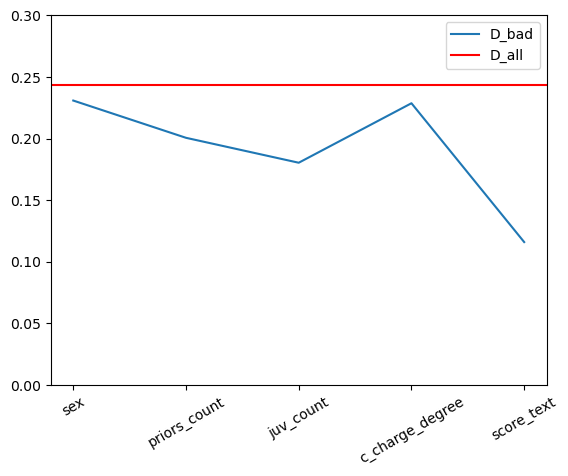

In [104]:
import matplotlib.pyplot as plt
plt.plot(D_bad_all)
plt.axhline(y = D_all, color = 'r', linestyle = '-')
plt.ylim([0,0.3])
plt.legend(["D_bad","D_all"])
plt.xticks([0.0,1.0,2.0,3.0,4.0],["sex","priors_count","juv_count","c_charge_degree","score_text"],rotation=30)

## Algorithm A6 : Local massaging

In [105]:

index_m= (X_train["juv_count"]==0)
X_train_m=X_train[index_m]
y_train_m=y_train[index_m]
X_train_f=X_train[-index_m]
y_train_f=y_train[-index_m]

In [106]:
from sklearn.linear_model import LogisticRegression
clf_m = LogisticRegression(random_state=0).fit(X_train_m, y_train_m)
clf_f = LogisticRegression(random_state=0).fit(X_train_f, y_train_f)

In [107]:
#get probability for logistic regression
X_train_m["prob_0"],X_train_m["prob_1"]=clf_m.predict_proba(X_train_m)[:,0],clf_m.predict_proba(X_train_m)[:,1]
X_train_f["prob_0"],X_train_f["prob_1"]=clf_f.predict_proba(X_train_f)[:,0],clf_f.predict_proba(X_train_f)[:,1]

In [108]:
index_b= (X_train["race"]==0)
X_train_b=X_train[index_b]
y_train_b=y_train[index_b]
X_train_w=X_train[-index_b]
y_train_w=y_train[-index_b]

In [109]:
index_b_m= (X_train_b["juv_count"]==0)
X_train_b_m=X_train_b[index_b_m]
y_train_b_m=y_train_b[index_b_m]
X_train_b_f=X_train_b[-index_b_m]
y_train_b_f=y_train_b[-index_b_m]

index_w_m= (X_train_w["juv_count"]==0)
X_train_w_m=X_train_w[index_w_m]
y_train_w_m=y_train_w[index_w_m]
X_train_w_f=X_train_w[-index_w_m]
y_train_w_f=y_train_w[-index_w_m]
print(X_train_b_m.shape,X_train_b_f.shape,X_train_w_m.shape,X_train_w_f.shape)

(2128, 7) (510, 7) (1607, 7) (147, 7)


In [110]:
#e_0
p_plus_e_0=(np.sum(clf_m.predict(X_train_b_m)==1)/len(X_train_b_m)-np.sum(clf_m.predict(X_train_w_m)==1)/len(X_train_w_m))/2
#e_1
p_plus_e_1=(np.sum(clf_f.predict(X_train_b_f)==1)/len(X_train_b_f)-np.sum(clf_f.predict(X_train_w_f)==1)/len(X_train_w_f))/2

In [111]:
G_0=len(X_train_b)
G_1=len(X_train_w)
delta_b_m=int(G_0*(np.sum(clf_m.predict(X_train_b_m)==1)/len(X_train_b_m)-p_plus_e_0))
delta_w_m=int(G_1*(np.sum(clf_m.predict(X_train_w_m)==1)/len(X_train_w_m)-p_plus_e_1))

delta_b_f=int(G_0*(np.sum(clf_f.predict(X_train_b_f)==1)/len(X_train_b_f)-p_plus_e_0))
delta_w_f=int(G_1*(np.sum(clf_f.predict(X_train_w_f)==1)/len(X_train_w_f)-p_plus_e_1))
print(delta_b_m,delta_w_m,delta_b_f,delta_w_f)

802 129 2232 881


In [112]:
index_p_to_n_m=X_train_m[(X_train_m["prob_1"]>=0.5)&(X_train_m["race"]==0)]["prob_1"].sort_values()[:delta_b_m]
index_n_to_p_m=X_train_m[(X_train_m["prob_1"]<0.5)&(X_train_m["race"]==1)]["prob_1"].sort_values(ascending=False)[:delta_w_m]
index_p_to_n_f=X_train_f[(X_train_f["prob_1"]>=0.5)&(X_train_f["race"]==0)]["prob_1"].sort_values()[:delta_b_f]
index_n_to_p_f=X_train_f[(X_train_f["prob_1"]<0.5)&(X_train_f["race"]==1)]["prob_1"].sort_values(ascending=False)[:delta_w_f]

In [113]:
y_train_1=y_train.copy()
y_train_1[y_train_1.index.isin(index_p_to_n_m.index)]=0
y_train_1[y_train_1.index.isin(index_n_to_p_m.index)]=1
y_train_1[y_train_1.index.isin(index_p_to_n_f.index)]=0
y_train_1[y_train_1.index.isin(index_n_to_p_f.index)]=1

In [125]:
from sklearn.linear_model import LogisticRegression
clf_new = LogisticRegression(random_state=0).fit(X_train, y_train_1)
print("Accuracy LM: ",clf_new.score(X_test,y_test))
print("calibration score LM: ",abs(clf_new.score(X_test_b,y_test_b)-clf_new.score(X_test_w,y_test_w)))

Accuracy LM:  0.6791808873720137
calibration score LM:  0.04116078096660625


## Algorithm A6: Local preferential sampling

In [115]:
index_p_to_n_m_u=X_train_m[(X_train_m["prob_1"]>=0.5)&(X_train_m["race"]==0)]["prob_1"].sort_values()[:int(delta_b_m/2)]
index_p_to_n_m_d=X_train_m[(X_train_m["prob_1"]<0.5)&(X_train_m["race"]==0)]["prob_1"].sort_values(ascending=False)[:int(delta_b_m/2)]

index_n_to_p_m_d=X_train_m[(X_train_m["prob_1"]<0.5)&(X_train_m["race"]==1)]["prob_1"].sort_values(ascending=False)[:int(delta_w_m/2)]
index_n_to_p_m_u=X_train_m[(X_train_m["prob_1"]>=0.5)&(X_train_m["race"]==1)]["prob_1"].sort_values()[:int(delta_w_m/2)]

index_p_to_n_f_u=X_train_f[(X_train_f["prob_1"]>=0.5)&(X_train_f["race"]==0)]["prob_1"].sort_values()[:int(delta_b_f/2)]
index_p_to_n_f_d=X_train_f[(X_train_f["prob_1"]<0.5)&(X_train_f["race"]==0)]["prob_1"].sort_values(ascending=False)[:int(delta_b_f/2)]

index_n_to_p_f_d=X_train_f[(X_train_f["prob_1"]<0.5)&(X_train_f["race"]==1)]["prob_1"].sort_values(ascending=False)[:int(delta_w_f/2)]
index_n_to_p_f_u=X_train_f[(X_train_f["prob_1"]>=0.5)&(X_train_f["race"]==1)]["prob_1"].sort_values()[:int(delta_w_f/2)]

In [116]:
X_train_1=X_train.copy()
y_train_1=y_train.copy()
df_new=pd.concat([X_train,y_train_1],axis=1)
df_new.drop(index_p_to_n_m_d.index,inplace=True)
df_new.drop(index_n_to_p_m_u.index,inplace=True)
df_new.drop(index_p_to_n_f_d.index,inplace=True)
df_new.drop(index_n_to_p_f_u.index,inplace=True)

In [117]:
df_dup_1=df_new[df_new.index.isin(index_p_to_n_m_u.index)]
df_dup_2=df_new[df_new.index.isin(index_n_to_p_m_d.index)]
df_dup_3=df_new[df_new.index.isin(index_p_to_n_f_u.index)]
df_dup_4=df_new[df_new.index.isin(index_n_to_p_f_d.index)]
df_new_all=df_new.append([df_dup_1,df_dup_2,df_dup_3,df_dup_4])

In [124]:
from sklearn.linear_model import LogisticRegression
clf_new2 = LogisticRegression(random_state=0).fit(df_new_all.drop("two_year_recid",axis=1), df_new_all["two_year_recid"])
print("Accuracy LPS: ",clf_new2.score(X_test,y_test))
print("calibration score LPS: ",abs(clf_new2.score(X_test_b,y_test_b)-clf_new2.score(X_test_w,y_test_w)))

Accuracy LPS:  0.6757679180887372
calibration score LPS:  0.03760802304491617


# Comparision plots:

### Accuracy plot:

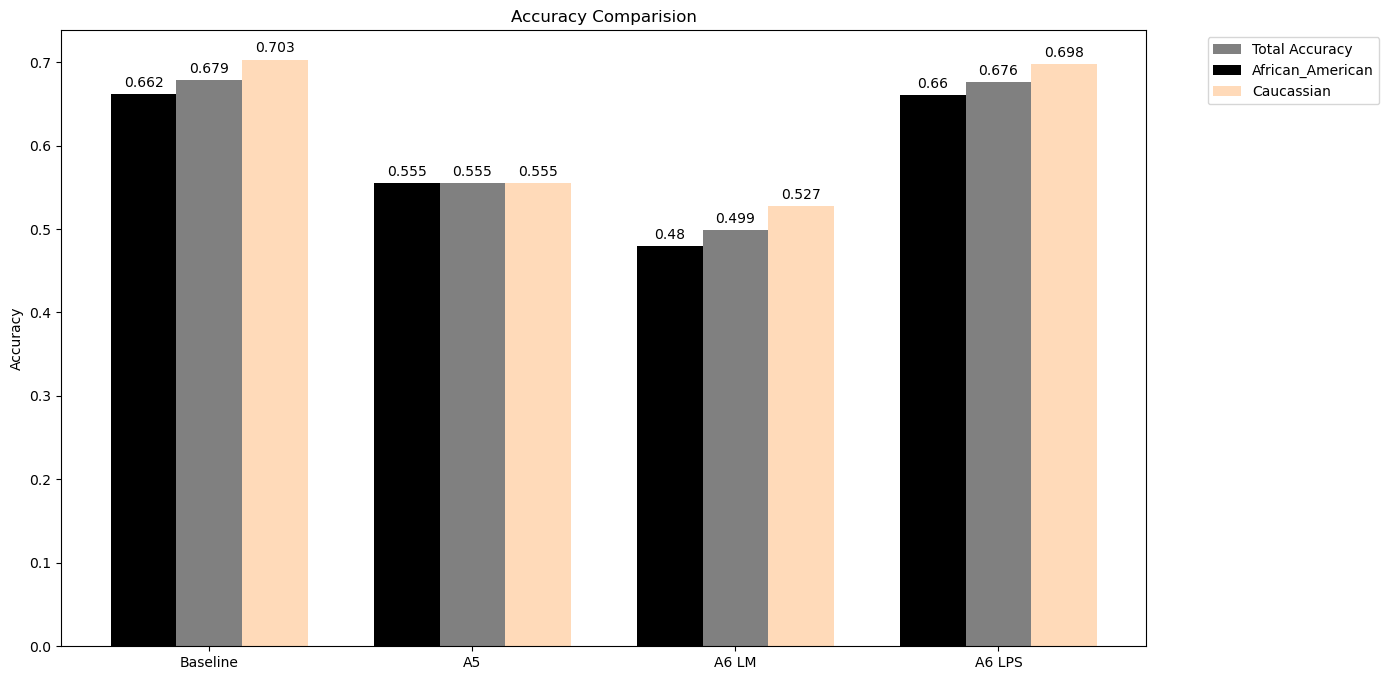

In [120]:
labels = ['Baseline', 'A5', 'A6 LM', 'A6 LPS']   # Add other models here

# Replace 0.555 with true scores:
Accuracy_score             = np.round_([clf.score(X_test,y_test),0.555, clf_new.score(X_test,y_test),clf_new2.score(X_test,y_test)],3)
Accuracy_African_American  = np.round_([clf.score(X_test_b,y_test_b),0.555,clf_new.score(X_test_b,y_test_b),clf_new2.score(X_test_b,y_test_b)],3)
Accuracy_Caucassian        = np.round_([clf.score(X_test_w,y_test_w),0.555,clf_new.score(X_test_w,y_test_w),clf_new2.score(X_test_w,y_test_w)],3)

x = np.arange(len(labels))  
width = 0.25 

fig, ax = plt.subplots(figsize=(14, 8))

rects0 = ax.bar(x , Accuracy_score , width, label='Total Accuracy', color="gray")
rects1 = ax.bar(x - width, Accuracy_African_American, width, label='African_American', color = "black")
rects2 = ax.bar(x + width, Accuracy_Caucassian, width, label='Caucassian', color = "peachpuff")

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparision')
ax.set_xticks(x, labels)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax.bar_label(rects0, padding=3)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()

### Calibration plot:

Text(0.5, 1.0, 'Calibration score Comparision')

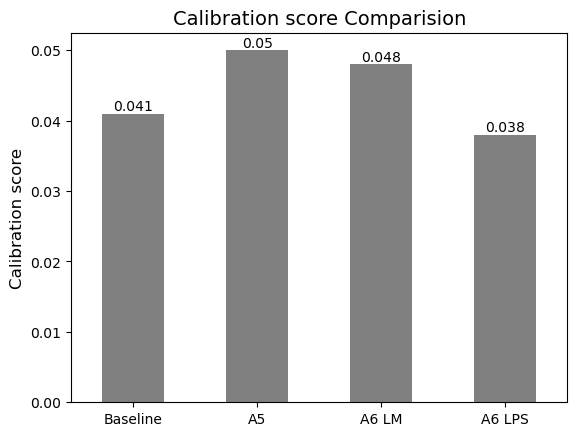

In [122]:
x_labels = ['Baseline','A5', 'A6 LM', 'A6 LPS']

Baseline_cal_score = abs(clf.score(X_test_b,y_test_b)-clf.score(X_test_w,y_test_w))
A5_cal_score = 0.05          # Enter score here
A6_LM_cal_score = abs(clf_new.score(X_test_b,y_test_b)-clf_new.score(X_test_w,y_test_w))
A6_LPS_cal_score = abs(clf_new2.score(X_test_b,y_test_b)-clf_new2.score(X_test_w,y_test_w))    

Calibration_score = np.round([Baseline_cal_score,A5_cal_score,A6_LM_cal_score,A6_LPS_cal_score],3)

score_series = pd.Series(Calibration_score)

plt.figure()
fig = score_series.plot(kind='bar',color="gray")
fig.set_xticklabels(x_labels, rotation=0)
fig.bar_label(fig.containers[0], label_type='edge')
plt.ylabel('Calibration score',fontsize = 12)
plt.title('Calibration score Comparision',fontsize = 14)

### False Positive Rate plot:

In [ ]:
'''FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.values.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN) '''

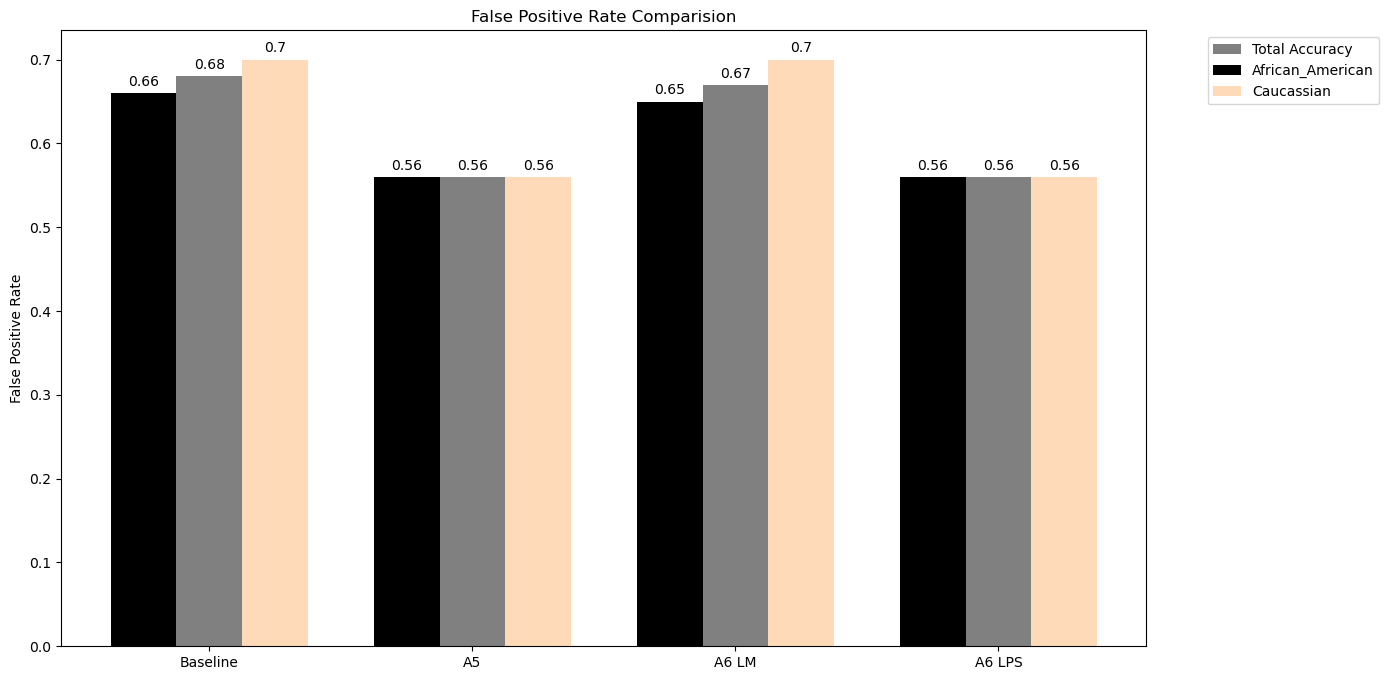

In [222]:
labels = ['Baseline', 'A5', 'A6 LM', 'A6 LPS']   # Add other models here

# Insert scores here:
FPR_score             = np.round_([clf.score(X_test,y_test),0.555, clf_new.score(X_test,y_test),0.555],2)
FPR_African_American  = np.round_([clf.score(X_test_b,y_test_b),0.555,clf_new.score(X_test_b,y_test_b),0.555],2)
FPR_Caucassian        = np.round_([clf.score(X_test_w,y_test_w),0.555,clf_new.score(X_test_w,y_test_w),0.555],2)

x = np.arange(len(labels))  
width = 0.25 

fig, ax = plt.subplots(figsize=(14, 8))

rects0 = ax.bar(x , Accuracy_score , width, label='Total Accuracy', color="gray")
rects1 = ax.bar(x - width, Accuracy_African_American, width, label='African_American', color = "black")
rects2 = ax.bar(x + width, Accuracy_Caucassian, width, label='Caucassian', color = "peachpuff")

ax.set_ylabel('False Positive Rate')
ax.set_title('False Positive Rate Comparision')
ax.set_xticks(x, labels)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax.bar_label(rects0, padding=3)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()